In [370]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [371]:
import pandas as pd

TS = 48 # Time steps

df = pd.read_csv('AusGrid_preprocess.csv', header=[0,1], index_col=0)
df = df.set_index(pd.to_datetime(df.index))
df.columns = df.columns.set_levels(df.columns.levels[0].astype('int64'), level=0)
df = df/1000.
df_date = df.index
df.head()

Customer             1                  3                4                  \
categories            GG     GC     CL   GG     GC   CL   GG     GC     CL   
2012-07-01 00:30:00  0.0  1.710  2.500  0.0  1.930  0.0  0.0  0.168  0.000   
2012-07-01 01:00:00  0.0  1.572  2.500  0.0  1.854  0.0  0.0  0.168  0.000   
2012-07-01 01:30:00  0.0  1.208  2.500  0.0  2.718  0.0  0.0  0.164  3.860   
2012-07-01 02:00:00  0.0  1.088  2.526  0.0  0.120  0.0  0.0  0.168  3.956   
2012-07-01 02:30:00  0.0  1.194  0.262  0.0  0.118  0.0  0.0  0.172  1.568   

Customer             5    ...  297               298         299         300  \
categories            GG  ...   GG     GC    CL   GG     GC   GG     GC   GG   
2012-07-01 00:30:00  0.0  ...  0.0  0.282  0.00  0.0  0.314  0.0  1.082  0.0   
2012-07-01 01:00:00  0.0  ...  0.0  0.514  0.00  0.0  0.254  0.0  0.200  0.0   
2012-07-01 01:30:00  0.0  ...  0.0  0.394  0.00  0.0  0.244  0.0  0.180  0.0   
2012-07-01 02:00:00  0.0  ...  0.0  0.546  2.66  0.0  0.240  0.0  0.188  0.0   
2012-07-01 02:30:00  0.0  ...  0.0  0.412  0.00  0.0  0.212  0.0  0.092  0.0   

Customer                           
categories              GC     CL  
2012-07-01 00:30:00  0.438  5.346  
2012-07-01 01:00:00  0.198  2.492  
2012-07-01 01:30:00  0.268  0.000  
2012-07-01 02:00:00  0.200  0.000  
2012-07-01 02:30:00  0.246  0.000  

[5 rows x 725 columns]

In [372]:
customers = sorted(df.columns.levels[0])
data_train = []
samples = list(range(1, 2)) #[201, 202, 203]

for s in samples:
    train = df[s][['GG', 'GC']]
    train['GC'].values[1]
    print(train.shape)
    data_train.append(train)

(17520, 2)


State : [PV.gen, LD, PV.charge, PV.dischare, BS, GD, COST]
- PV.gen : PV generatoin power
- LD : Load consumption power
- PV.charge : Battery charging power
- PV.dischare : Battery discharging power
- BS : Battery status
- GD : Grid imort(+)/export(-) power
- COST : Cost for power

Action : [0, 1]
- 0 : discharging
- 1 : charging

Cost funciton(Reward)
- Self consumption : (PV - PV.charge + PV.dischare - GD) / PV
- Self sufficency : (PV - PV.charge + PV.dischare - GD) / LD

In [373]:
BTMAX = 0.95
BTMIN = 0.10
C_A = 0.01
C_B = 1.
C_C = 0.
R_MAX = 3.
def sigmoid(x):
    return 1/(1+math.exp(-x))

class Environment:
    def __init__(self, data_env, capacity=50.):
        self.capacity = capacity
        self.data_env = data_env
        self.pos = 0
        self.btmax = capacity*BTMAX
        self.btmin = capacity*BTMIN
        self.state = np.array([self.data_env['GG'].values[self.pos], self.data_env['GC'].values[self.pos], 0., 0., self.btmin, 0., 0])

        self.ss = np.zeros((4, TS)) #pv, ld, import, export
        self.tss = 0.0

    def reset(self):
        self.ss = np.zeros(self.ss.shape)
        self.tss = 0.0
        
        self.state = np.array([0., 0., 0., 0., self.btmin, 0., 0])
        return torch.as_tensor(self.state, dtype=torch.float32).squeeze(0)

    def step(self, action):
        charging = 0.0
        discharging = 0.0
        batt_state = 0.0
        grid_state = 0.0
        reward = 0.

        self.state[0] = self.data_env['GG'].values[self.pos]  # PV generation power
        self.state[1] = self.data_env['GC'].values[self.pos]  # Load consumption power
        
        if action == 1: # charge battery
            charging = max(0, self.state[0] - self.state[1])  # Charging power
            charging = min(self.btmax - self.state[4], charging)
            batt_state = charging # Update battery status
            # if self.state[0] > self.state[1]:
            #     reward = 1.
        elif action == 0: # discharge battery
            discharging = min(max(self.state[4]-self.btmin, 0), max(0, self.state[1] - self.state[0])) # discharing power
            batt_state = -discharging # Update battery status
            # if self.state[0] < self.state[1]:
            #     reward = 1.
            
        grid_state = self.state[1] - (self.state[0] - charging + discharging) # Grid power + : import, - : export
        cost = C_A*grid_state**2 + C_B*abs(grid_state) + C_C
        cost = cost if grid_state > 0 else -cost

        normal_v = abs(self.state[0] - self.state[1])       
        d = abs(grid_state) / normal_v if normal_v else abs(grid_state)
        reward = max((min(3, np.log(1/d)) if d else 3), 0)

        # normal_v2 = C_A*normal_v**2 + C_B*abs(normal_v)
        # d = (abs(cost) - C_C) /normal_v2 if normal_v2 else (abs(cost) - C_C)
        # reward = min(R_MAX, np.log(1/d)) if d else R_MAX
                
        self.state[2] = charging
        self.state[3] = discharging
        self.state[4] += batt_state
        self.state[5] = grid_state
        self.state[6] = cost

        self.ss[0][self.pos%TS] = self.state[0]
        self.ss[1][self.pos%TS] = self.state[1]
        self.ss[2][self.pos%TS] = grid_state if grid_state > 0 else 0
        self.ss[3][self.pos%TS] = grid_state if grid_state < 0 else 0

        sc = (self.ss[0].sum() + self.ss[3].sum() - self.state[4])/self.ss[0].sum() if self.ss[0].sum() else 0
        # ss1= (self.ss[1].sum() - self.ss[2].sum() - self.state[4ß])/self.ss[1].sum() if self.ss[1].sum() else 0
        ss = (self.ss[0].sum() + self.ss[3].sum() - self.state[4])/self.ss[1].sum() if self.ss[1].sum() else 0

        self.tss += sc        
        # reward = np.exp(sc + ss - 1)
        nor = (self.ss[2]**2).sum() + (self.ss[3]**2).sum()
        nor = math.sqrt(nor)
        # reward = sigmoid(max(0, sc + ss)) - 
        reward = 1 - sigmoid(nor)
        # print(sc, ss)
        #/self.tss/(self.pos+1) if self.tss else 0
        
        done = ((self.pos + 1) % TS == 0)
        self.pos += 1

        return torch.as_tensor(self.state, dtype=torch.float32), torch.tensor([reward]), done 

    def render(self):
        return 0
    

In [374]:
class A2C(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(A2C, self).__init__()
        self.num_actions = n_actions
        
        self.layer1_actor = nn.Linear(n_observations, 256)
        self.layer1_critic = nn.Linear(n_observations, 256)
        
        self.layer2_actor = nn.Linear(256, 128)
        self.layer2_critic = nn.Linear(256, 128)
        
        self.layer3_actor = nn.Linear(128, n_actions)
        self.layer3_critic = nn.Linear(128, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        px = F.relu(self.layer1_actor(x))
        px = F.relu(self.layer2_actor(px))
        policy_dist = F.softmax(self.layer3_actor(px), dim=-1)

        vx = F.relu(self.layer1_critic(x))
        vx = F.relu(self.layer2_critic(vx))
        value = self.layer3_critic(vx)
        
        return value, policy_dist

In [375]:
BATCH_SIZE = 128
GAMMA = 0.90
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

n_observaons = 7
print(n_observaons)
n_actions = 2
a2c_net = A2C(n_observaons, n_actions).to(device)
optimizer = optim.Adam(a2c_net.parameters(), lr=1e-4)

7


In [376]:
all_lengths = []
average_lengths = []
all_rewards = []
all_sc_ss = []

entropy_term = 0
    
num_episodes = len(data_train)*20

for i_episode in range(num_episodes):

    env = Environment(data_train[i_episode%len(data_train)])
    state = env.reset()    

    log_probs = []
    values = []
    rewards = []
    
    total_export = 0.0
    total_pv = 0.0
    total_ld = 0.0
        
    for i in range(env.data_env.shape[0]):
        value, policy_dist = a2c_net.forward(state)
        value = value.detach().numpy()[0]
        dist = policy_dist.detach().numpy()
        action = np.random.choice(n_actions, p=np.squeeze(dist))
        
        log_prob = torch.log(policy_dist.squeeze(0)[action])
        entropy = -np.sum(dist * np.log(dist + 1e-10))
        new_state, reward, done = env.step(action)

        rewards.append(reward.squeeze(0))
        values.append(value)
        log_probs.append(log_prob)
        entropy_term += entropy
        state = new_state

        total_export += state.numpy()[5] if state.numpy()[5] < 0 else 0
        total_pv += state.numpy()[0]
        total_ld += state.numpy()[1]

        if done:
            Qval, _ = a2c_net.forward(new_state)
            Qval = Qval.detach().numpy()[0]
            all_rewards.append(np.sum(rewards))
            all_lengths.append(i)
            average_lengths.append(np.mean(all_lengths[-10:]))
            # print("episode: {}, reward: {}, total length: {}, average length: {} \n".format(i_episode, np.sum(rewards), i, average_lengths[-1]))

            # compute Q values
            Qvals = np.zeros_like(values)
            for t in reversed(range(len(rewards))):
                Qval = rewards[t] + GAMMA * Qval
                Qvals[t] = Qval

            #update actor critic
            values = torch.FloatTensor(values)
            Qvals = torch.FloatTensor(Qvals)
            log_probs = torch.stack(log_probs)
            
            advantage = Qvals - values
            actor_loss = -(log_probs * advantage).mean()
            critic_loss = 0.05 * advantage.pow(2).mean()
            ac_loss = actor_loss + critic_loss #- 0.0001 * entropy_term
            print(actor_loss, critic_loss, 0.001*entropy_term)

            optimizer.zero_grad()
            ac_loss.backward()
            optimizer.step()

            log_probs = []
            values = []
            rewards = []

    sc = (total_pv + total_export)/total_pv
    ss = (total_pv + total_export)/total_ld
    all_sc_ss.append([sc, ss])
    print('sc and ss', sc, ss)


tensor(-0.0130, grad_fn=<NegBackward0>) tensor(0.0003) 0.03312193083763123
tensor(0.0109, grad_fn=<NegBackward0>) tensor(0.0001) 0.06631429803371429
tensor(-0.0283, grad_fn=<NegBackward0>) tensor(0.0001) 0.0994698869585991
tensor(-0.0501, grad_fn=<NegBackward0>) tensor(0.0004) 0.13257749092578888
tensor(-0.0520, grad_fn=<NegBackward0>) tensor(0.0004) 0.16572521525621414
tensor(-0.0551, grad_fn=<NegBackward0>) tensor(0.0004) 0.1988744290471077
tensor(-0.0537, grad_fn=<NegBackward0>) tensor(0.0003) 0.23210511338710785
tensor(-0.0439, grad_fn=<NegBackward0>) tensor(0.0003) 0.2653004665374756
tensor(-0.0539, grad_fn=<NegBackward0>) tensor(0.0004) 0.29849468982219696
tensor(-0.0543, grad_fn=<NegBackward0>) tensor(0.0004) 0.33167683231830597
tensor(-0.0593, grad_fn=<NegBackward0>) tensor(0.0004) 0.3648642588853836
tensor(-0.0402, grad_fn=<NegBackward0>) tensor(0.0003) 0.39810028016567234
tensor(-0.0552, grad_fn=<NegBackward0>) tensor(0.0004) 0.43123320877552035
tensor(-0.0479, grad_fn=<NegBa

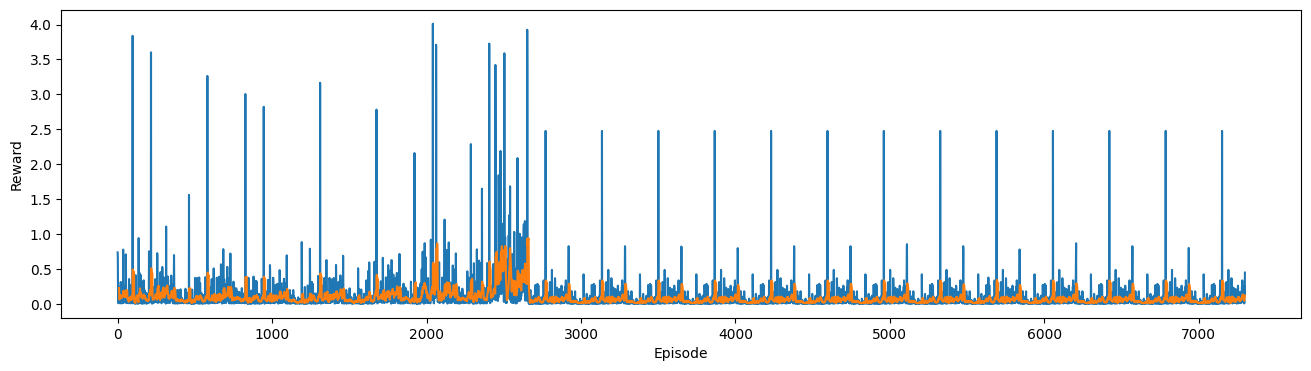

[[0.44190117877941176, 0.4281184974461735], [0.38110969959171187, 0.36922307472008914], [0.3981813450655197, 0.3857622639328627], [0.36861636363878814, 0.3571193997965925], [0.3975532178557966, 0.38515372770316886], [0.45858535226832586, 0.4442822997354874], [0.5208074673273089, 0.5045637375007216], [0.3760661108592971, 0.36433679305000627], [0.25026064522314023, 0.24245513827045803], [0.2502127488194613, 0.24240873573215133], [0.2502500884558844, 0.2424449107636025], [0.25027921729594793, 0.24247313108941101], [0.2502127488267441, 0.24240873573920696], [0.2503321965773352, 0.24252445797295985], [0.2503562425243965, 0.24254775393870942], [0.2515288246021153, 0.24368376375572753], [0.2502590812588077, 0.24245362308540702], [0.2503505731533268, 0.2425422613925467], [0.2502287794502286, 0.2424242663753964], [0.2503001353159827, 0.24249339668664607]]


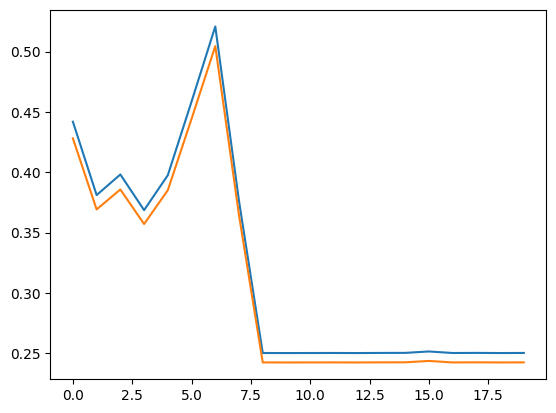

In [377]:
# Plot results
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.figure(figsize=(16, 4))
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

print(all_sc_ss)
plt.plot(np.array(all_sc_ss)[:, 0])
plt.plot(np.array(all_sc_ss)[:, 1])
plt.show()

In [378]:
customers = sorted(df.columns.levels[0])
data_test = df[1][['GG', 'GC']]
data_test['GC'].values[1]
data_test.shape

(17520, 2)

In [379]:
capacity = 50.
env = Environment(data_test, capacity)
state = torch.tensor(np.array([data_test['GG'].values[0], data_test['GC'].values[0], 0., 0., capacity*BTMIN, 0., 0.0]), dtype=torch.float32).squeeze(0)
df_out = pd.DataFrame(columns=['PV', 'LD', 'PV.C', 'PV.D', 'BT', 'GD', 'COST', 'AC', 'RD'])
state = state.clone().detach().unsqueeze(0)

with torch.no_grad():
    for i in range(env.data_env.shape[0]):
        _, logits = a2c_net.forward(state)
        # prob = F.softmax(logits, dim=1).data
        action = torch.argmax(logits, dim=1).numpy()[0]
        
        observation, reward, done=env.step(action.item())
        reward = torch.tensor([reward], device=device)
        next_state = observation.clone().detach().unsqueeze(0)
        st = next_state.numpy().squeeze(0)
        at = action.item()
        # print('Current x : ', t, 'Action :', at, ', y : ', next_state, 'reward :', reward.item())

        st = np.concatenate((st, np.array([at-1, reward.item()])))
        df_out.loc[i] = st
        state = next_state


                      PV     LD    BT   AC     GD        RD
2012-07-01 00:30:00  0.0  1.710   5.0  0.0  1.710  0.153164
2012-07-01 01:00:00  0.0  1.572   5.0  0.0  1.572  0.089254
2012-07-01 01:30:00  0.0  1.208   5.0  0.0  1.208  0.067981
2012-07-01 02:00:00  0.0  1.088   5.0  0.0  1.088  0.055452
2012-07-01 02:30:00  0.0  1.194   5.0  0.0  1.194  0.044093
...                  ...    ...   ...  ...    ...       ...
2012-07-05 22:30:00  0.0  0.828  47.5  0.0  0.828  0.000111
2012-07-05 23:00:00  0.0  1.864  47.5  0.0  1.864  0.000133
2012-07-05 23:30:00  0.0  0.140  47.5  0.0  0.140  0.000135
2012-07-06 00:00:00  0.0  0.188  47.5  0.0  0.188  0.000137
2012-07-06 00:30:00  0.0  0.112  47.5  0.0  0.112  0.000143

[241 rows x 6 columns]


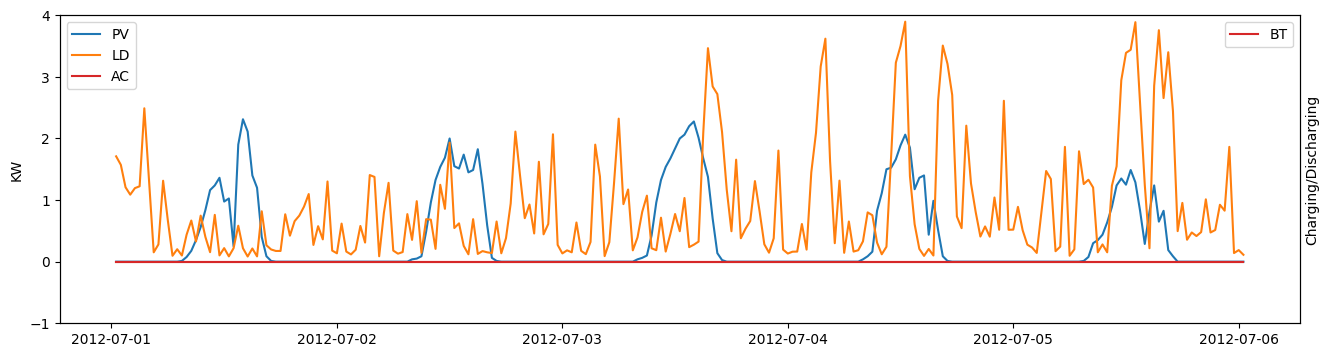

In [380]:
start_pos = 0
duration = TS*5
df_dis = df_out[['PV', 'LD', 'BT', 'AC', 'GD', 'RD']]
df_dis = df_dis.set_index(pd.Index(df_date.values))

pv =  df_dis['PV'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ld =  df_dis['LD'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
bt =  df_dis['BT'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ac =  df_dis['AC'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values

fig, ax1 = plt.subplots(figsize=(16, 4))
ax1.plot(df_date.values[start_pos:start_pos+duration+1], pv, label='PV', color='#1f77b4')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ld, label='LD', color='#ff7f0e')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='AC', color='#d62728')
ax1.legend(loc='upper left')
ax1.set_ylabel('KW')
ax1.set_ylim(-1, 4)

ax2 = ax1.twinx()
ax2.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='BT', color='#d62728')
ax2.legend(loc='upper right')
ax2.set_ylabel('Charging/Discharging')
ax2.set_yticks([])
ax2.set_ylim(-1, 4)

# ax = df_dis[['PV', 'LD', 'BT', 'AC']].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].plot(figsize=(16,5))
# ax.set_ylim(-1, 3)
# ax.set_ylabel('KW')
print(df_dis.loc[df_date.values[start_pos]:df_date.values[start_pos+duration]])
plt.show()

Text(0, 0.5, 'KW')

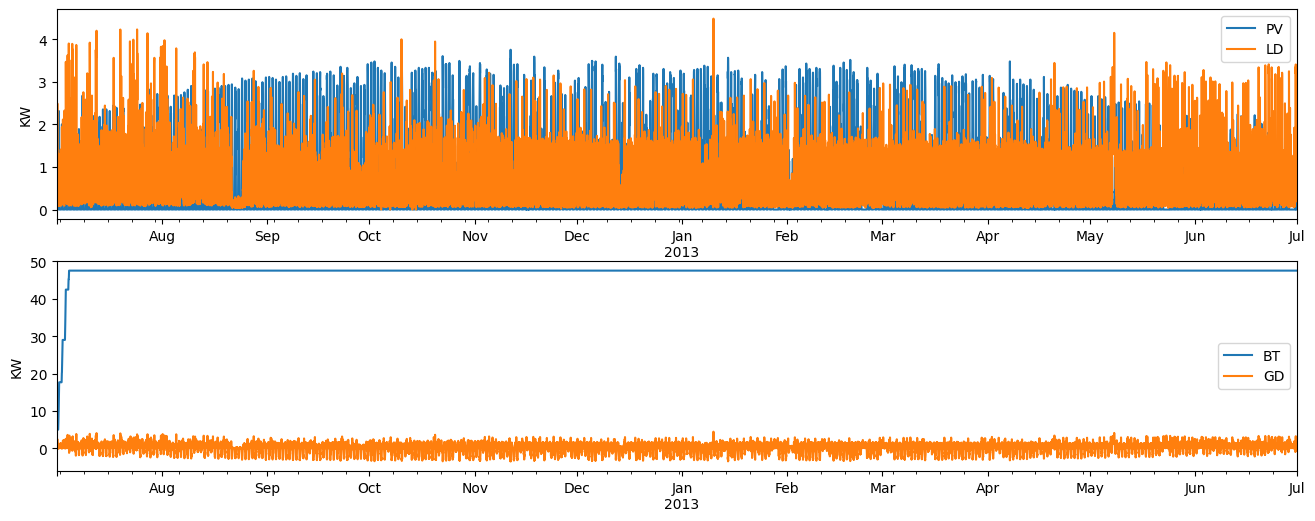

In [381]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
df_dis[['PV', 'LD']].plot(ax=axes[0])
df_dis[['BT', 'GD']].plot(ax=axes[1])

axes[0].set_ylabel('KW')
axes[1].set_ylabel('KW')

In [382]:
Egen = df_out['PV'].sum()
print(Egen, 'KW')
Eload = df_out['LD'].sum()
print(Eload, 'KW')
GDimport = df_out[df_out['GD'] > 0]['GD'].sum()
print(GDimport)
GDexport = df_out[df_out['GD'] < 0]['GD'].sum()
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Egen + GDexport)/Eload
print('SC :', SC)
print('SS :', SS)

10230.414012374356 KW
10559.768004506826 KW
8042.488002257887
-7670.634000777034
SC : 0.2502127488194613
SS : 0.24240873573215133


[    0.             0.             0.         ... -7670.63400078
 -7670.63400078 -7670.63400078]


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_897/1945581510.py:8: RuntimeWarning: invalid value encountered in divide
  ss =  (c_pv + c_ex) / c_pv


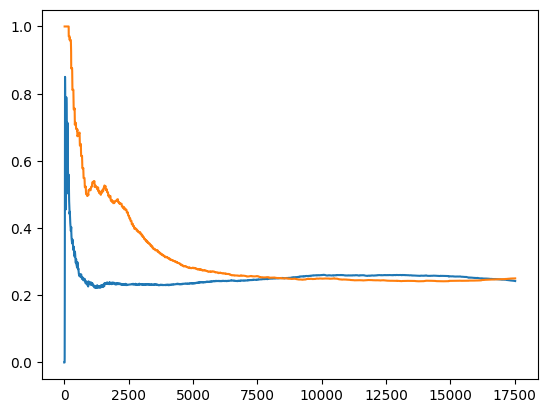

In [383]:
c_pv = np.cumsum(df_out['PV'].values)
c_ld = np.cumsum(df_out['LD'].values)
c_ex = df_out['GD'].values
c_ex[c_ex > 0] = 0
c_ex = np.cumsum(c_ex)

sc =  (c_pv + c_ex) / c_ld
ss =  (c_pv + c_ex) / c_pv

sc[np.isnan(sc)] = 0
print(c_ex)
# plt.plot(c_pv)
# plt.plot(c_ld)
# plt.plot(c_ex)
plt.plot(sc)
plt.plot(ss)

In [384]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
 
max_len = len(df_out)

pv =  df_out['PV'].iloc[:].values
ld =  df_out['LD'].iloc[:].values
bt =  df_out['BT'].iloc[:].values
ac =  df_out['AC'].iloc[:].values
gd =  df_out['GD'].iloc[:].values
# ct =  df_out['COST'].iloc[:].values

def interactive_plot(window, start):    
    window *= 48
    start *= 48
    fig, ax1 = plt.subplots(figsize=(16, 5))    
    ax1.plot(df_date.values, pv, label='PV', color='#1f77b4')
    ax1.plot(df_date.values, ld, label='LD', color='#ff7f0e')
    ax1.plot(df_date.values, ac, label='AC', color='#d62728')
    ax1.plot(df_date.values, gd, label='GD', color='black')
    # ax1.plot(df_date.values, ct, label='COST', color='grey')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('KW')

    ax2 = ax1.twinx()
    ax2.plot(df_date.values, bt, label='BT', color='#2ca02c')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('KW')
    
    start = min(start, max_len-window)
    ax1.set_xlim(df_date.values[start], df_date.values[start+window-1])
    
    plt.show()

 
 
interact(interactive_plot, window=(1, 10, 1), start=(0, 365, 1))

interactive(children=(IntSlider(value=5, description='window', max=10, min=1), IntSlider(value=182, descriptio…

<function __main__.interactive_plot(window, start)>